In [1]:
!pip install pandas scikit-learn sentence-transformers transformers matplotlib tensorflow tensorflow-hub gensim torch xgboost openai==0.28.0 tqdm

In [3]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
#import xgboost as xgb
from matplotlib import pyplot as plt

# For embeddings
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, AlbertTokenizer, AlbertModel, TFBertForSequenceClassification
import tensorflow_hub as hub
import openai
import gensim
import torch

# For Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Bidirectional, Embedding, Flatten


/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# df=pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

In [4]:
# X = df['URL'].values  # Select URL column
# y = df['label'].values


In [5]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# def get_sbert_embeddings(texts):
#     model = SentenceTransformer('all-MiniLM-L6-v2')
#     embeddings = model.encode(texts, batch_size=32, show_progress_bar=True)
#     return embeddings

In [7]:
#Generate training embeddings
# embeddings_dict = {}

In [4]:
# SBERT
# print("Generating SBERT embeddings...")
# embeddings_dict['SBERT'] = get_sbert_embeddings(X_train)
# embeddings_dict['SBERT'].shape

In [5]:
#Generate test embeddings
# test_embeddings_dict = {}

In [6]:
# SBERT
# print("Generating SBERT test embeddings...")
# test_embeddings_dict['SBERT'] = get_sbert_embeddings(X_test)
# test_embeddings_dict['SBERT'].shape

In [7]:
#Load Embeddings
with open('embeddings_dict.pkl', 'rb') as f:
  embeddings_dict = pickle.load(f)

with open('test_embeddings_dict.pkl', 'rb') as f:
  test_embeddings_dict = pickle.load(f)

#Load manual scaled features
with open('X_train_manual_scaled.pkl', 'rb') as f:
  X_train_manual_scaled = pickle.load(f)

with open('X_test_manual_scaled.pkl', 'rb') as f:
  X_test_manual_scaled = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
  y_train= pickle.load(f)

with open('y_test.pkl', 'rb') as f:
  y_test= pickle.load(f)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, Dense, Dropout, InputLayer

def build_ffnn(input_dim):
    model = Sequential([
        InputLayer(input_shape=(input_dim,)),  # Explicit Input layer
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [9]:
def build_rnn(input_dim, timesteps=1):
    model = Sequential([
        InputLayer(input_shape=(timesteps, input_dim)),
        SimpleRNN(128, activation='tanh'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [10]:
def build_lstm(input_dim, timesteps=1):
    model = Sequential([
        InputLayer(input_shape=(timesteps, input_dim)),
        LSTM(128),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [11]:
def build_cnn(input_dim, timesteps=1):
    model = Sequential([
        InputLayer(input_shape=(timesteps, input_dim)),
        Conv1D(128, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [12]:
import os
def create_model_dir(base_dir='saved_models', embedding='SBERT', model_type='FFNN'):
    path = os.path.join(base_dir, embedding, model_type)
    os.makedirs(path, exist_ok=True)
    return path

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.metrics import f1_score, classification_report, roc_auc_score

# Define a custom callback to compute F1-Score at the end of each epoch
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_target = self.validation_data[1]
        _val_f1 = f1_score(val_target, val_predict)
        self.f1_scores.append(_val_f1)
        logs['val_f1'] = _val_f1
        print(f" — val_f1: {_val_f1:.4f}")

# Function to plot and save graphs
def plot_and_save(history, f1_callback, model_dir, model_name, emb):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot Loss
    plt.figure()
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation loss')
    plt.title(f'{model_name} with {emb} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    loss_path = os.path.join(model_dir, 'loss.png')
    plt.savefig(loss_path)
    plt.close()

    # Plot Accuracy
    if 'accuracy' in history.history:
        plt.figure()
        plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
        plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
        plt.title(f'{model_name} with {emb} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        acc_path = os.path.join(model_dir, 'accuracy.png')
        plt.savefig(acc_path)
        plt.close()

    # Plot F1-Score
    plt.figure()
    plt.plot(epochs, f1_callback.f1_scores, 'bo-', label='Validation F1-Score')
    plt.title(f'{model_name} with {emb} - F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    f1_path = os.path.join(model_dir, 'f1_score.png')
    plt.savefig(f1_path)
    plt.close()

In [14]:

# Define list of models
model_builders = {
    'FFNN': build_ffnn,
    'RNN': build_rnn,
    'LSTM': build_lstm,
    # 'CNN': build_cnn
}

# Define embedding types
# embedding_types = ['SBERT', 'BERT-CLS', 'USE', 'FastText', 'RoBERTa', 'ALBERT']

# Initialize results storage
results = []

# Early Stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Iterate through each embedding type
for emb in embeddings_dict.keys():
    print(f"\nProcessing Embedding: {emb}")

    X_train_emb = embeddings_dict[emb]
    X_test_emb = test_embeddings_dict[emb]

    # Concatenate with manual features
    X_train_combined = np.hstack((X_train_emb, X_train_manual_scaled))
    X_test_combined = np.hstack((X_test_emb, X_test_manual_scaled))
    # X_train_combined = X_train_emb
    # X_test_combined = X_test_emb
    # Get input dimension
    input_dim = X_train_combined.shape[1]

    # For RNN, LSTM, CNN: reshape to (samples, timesteps, features)
    X_train_rnn = X_train_combined.reshape((X_train_combined.shape[0], 1, X_train_combined.shape[1]))
    X_test_rnn = X_test_combined.reshape((X_test_combined.shape[0], 1, X_test_combined.shape[1]))

    # Iterate through each model
    for model_name, builder in model_builders.items():
        print(f"Training Model: {model_name} with Embedding: {emb}")

        # Select input based on model type
        if model_name in ['RNN', 'LSTM', 'CNN']:
            X_train_input = X_train_rnn
            X_test_input = X_test_rnn
            model_input_dim = X_train_combined.shape[1]
            timesteps = 1
        else:
            X_train_input = X_train_combined
            X_test_input = X_test_combined
            model_input_dim = input_dim
            timesteps = None  # Not needed for FFNN

        # Build model
        if model_name == 'FFNN':
            model = builder(model_input_dim)
        elif model_name == 'RNN':
            model = builder(model_input_dim, timesteps=1)
        elif model_name == 'LSTM':
            model = builder(model_input_dim, timesteps=1)
        elif model_name == 'CNN':
            model = builder(model_input_dim, timesteps=1)
        else:
            raise ValueError(f"Unknown model type: {model_name}")

        # Define directory and checkpoint path
        model_dir = create_model_dir(embedding=emb, model_type=model_name)
        checkpoint_path = os.path.join(model_dir, 'best_model.keras')

        # Define callbacks
        checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',      # You can change this to 'val_accuracy' or another metric
            verbose=1,
            save_best_only=True,
            mode='min'               # Use 'max' if monitoring metrics like accuracy
        )
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )

        # Initialize F1 callback
        f1_callback = F1ScoreCallback(validation_data=(X_test_input, y_test))

        # Train model with callbacks
        history = model.fit(
            X_train_input, y_train,
            epochs=50,                        # Increased epochs to allow convergence
            batch_size=32,
            validation_split=0.1,
            callbacks=[checkpoint, early_stop, f1_callback],
            verbose=1
        )

        # Plot and save the graphs
        plot_and_save(history, f1_callback, model_dir, model_name, emb)

        # Evaluate model
        y_pred_prob = model.predict(X_test_input).flatten()
        y_pred = (y_pred_prob >= 0.5).astype(int)

        acc = np.mean(y_pred == y_test)
        f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
        auc = roc_auc_score(y_test, y_pred_prob)

        # Store results
        results.append({
            'Embedding': emb,
            'Model': model_name,
            'Accuracy': acc,
            'F1-Score': f1,
            'ROC-AUC': auc
        })

        print(f"Model: {model_name}, Embedding: {emb}, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {auc:.4f}")



Processing Embedding: SBERT
Training Model: FFNN with Embedding: SBERT


/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5300/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9883 - loss: 0.0292
Epoch 1: val_loss improved from inf to 0.00372, saving model to saved_models/SBERT/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
 — val_f1: 0.9992
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - accuracy: 0.9883 - loss: 0.0292 - val_accuracy: 0.9989 - val_loss: 0.0037 - val_f1: 0.9992
Epoch 2/50
5301/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0051
Epoch 2: val_loss improved from 0.00372 to 0.00368, saving model to saved_models/SBERT/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
 — val_f1: 0.9993
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 0.9987 - val_loss: 0.0037 - val_f1: 0.9993
Epoch 3/50
5299/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0039
Epoch 3: val_loss improved from 0.00368 to 0.00120, saving model to saved_models/SBERT/FFNN/best_model.keras
1474/1474 ━━━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5292/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0347
Epoch 1: val_loss improved from inf to 0.00177, saving model to saved_models/SBERT/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step
 — val_f1: 0.9997
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9873 - loss: 0.0346 - val_accuracy: 0.9995 - val_loss: 0.0018 - val_f1: 0.9997
Epoch 2/50
5288/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0036
Epoch 2: val_loss did not improve from 0.00177
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step
 — val_f1: 0.9994
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9990 - loss: 0.0036 - val_accuracy: 0.9993 - val_loss: 0.0021 - val_f1: 0.9994
Epoch 3/50
5285/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0022
Epoch 3: val_loss improved from 0.00177 to 0.00147, saving model to saved_models/SBERT/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step
 — val_f1: 0.9998
5306/5306 ━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5294/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9825 - loss: 0.0429
Epoch 1: val_loss improved from inf to 0.00400, saving model to saved_models/SBERT/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9990
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.9825 - loss: 0.0429 - val_accuracy: 0.9988 - val_loss: 0.0040 - val_f1: 0.9990
Epoch 2/50
5301/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0032
Epoch 2: val_loss improved from 0.00400 to 0.00194, saving model to saved_models/SBERT/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9995
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 0.9994 - val_loss: 0.0019 - val_f1: 0.9995
Epoch 3/50
5299/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0031
Epoch 3: val_loss improved from 0.00194 to 0.00104, saving model to saved_models/SBERT/LSTM/best_model.keras
1474/1474 ━━━━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5301/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9767 - loss: 0.0544
Epoch 1: val_loss improved from inf to 0.01259, saving model to saved_models/BERT_CLS/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step
 — val_f1: 0.9959
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9767 - loss: 0.0544 - val_accuracy: 0.9962 - val_loss: 0.0126 - val_f1: 0.9959
Epoch 2/50
5299/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.0120
Epoch 2: val_loss improved from 0.01259 to 0.00626, saving model to saved_models/BERT_CLS/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9984
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9965 - loss: 0.0120 - val_accuracy: 0.9980 - val_loss: 0.0063 - val_f1: 0.9984
Epoch 3/50
5305/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9967 - loss: 0.0117
Epoch 3: val_loss improved from 0.00626 to 0.00298, saving model to saved_models/BERT_CLS/FFNN/best_model.keras
1474/1

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5297/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9818 - loss: 0.0446
Epoch 1: val_loss improved from inf to 0.00733, saving model to saved_models/BERT_CLS/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step
 — val_f1: 0.9980
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9819 - loss: 0.0445 - val_accuracy: 0.9973 - val_loss: 0.0073 - val_f1: 0.9980
Epoch 2/50
5292/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0086
Epoch 2: val_loss improved from 0.00733 to 0.00328, saving model to saved_models/BERT_CLS/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step
 — val_f1: 0.9993
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9972 - loss: 0.0086 - val_accuracy: 0.9988 - val_loss: 0.0033 - val_f1: 0.9993
Epoch 3/50
5301/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0077
Epoch 3: val_loss did not improve from 0.00328
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step
 — val_f1: 0.9990
5306/530

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5303/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9838 - loss: 0.0403
Epoch 1: val_loss improved from inf to 0.00459, saving model to saved_models/BERT_CLS/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9990
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9838 - loss: 0.0403 - val_accuracy: 0.9984 - val_loss: 0.0046 - val_f1: 0.9990
Epoch 2/50
5300/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9970 - loss: 0.0102
Epoch 2: val_loss improved from 0.00459 to 0.00360, saving model to saved_models/BERT_CLS/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step
 — val_f1: 0.9994
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9970 - loss: 0.0102 - val_accuracy: 0.9988 - val_loss: 0.0036 - val_f1: 0.9994
Epoch 3/50
5298/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0079
Epoch 3: val_loss did not improve from 0.00360
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9989
5306/5306 

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5297/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9853 - loss: 0.0359
Epoch 1: val_loss improved from inf to 0.00243, saving model to saved_models/USE/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9994
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.9853 - loss: 0.0359 - val_accuracy: 0.9990 - val_loss: 0.0024 - val_f1: 0.9994
Epoch 2/50
5297/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0061
Epoch 2: val_loss improved from 0.00243 to 0.00139, saving model to saved_models/USE/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9995
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9981 - loss: 0.0061 - val_accuracy: 0.9994 - val_loss: 0.0014 - val_f1: 0.9995
Epoch 3/50
5298/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0049
Epoch 3: val_loss did not improve from 0.00139
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9996
5306/5306 ━━━━━━━━━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5295/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9843 - loss: 0.0419
Epoch 1: val_loss improved from inf to 0.00500, saving model to saved_models/USE/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step
 — val_f1: 0.9989
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9843 - loss: 0.0419 - val_accuracy: 0.9983 - val_loss: 0.0050 - val_f1: 0.9989
Epoch 2/50
5289/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0049
Epoch 2: val_loss improved from 0.00500 to 0.00435, saving model to saved_models/USE/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step
 — val_f1: 0.9990
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9985 - loss: 0.0049 - val_accuracy: 0.9990 - val_loss: 0.0044 - val_f1: 0.9990
Epoch 3/50
5305/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0033
Epoch 3: val_loss improved from 0.00435 to 0.00152, saving model to saved_models/USE/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5300/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9780 - loss: 0.0492
Epoch 1: val_loss improved from inf to 0.00556, saving model to saved_models/USE/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9989
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9780 - loss: 0.0492 - val_accuracy: 0.9982 - val_loss: 0.0056 - val_f1: 0.9989
Epoch 2/50
5302/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - loss: 0.0041
Epoch 2: val_loss improved from 0.00556 to 0.00221, saving model to saved_models/USE/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9995
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.9987 - loss: 0.0041 - val_accuracy: 0.9993 - val_loss: 0.0022 - val_f1: 0.9995
Epoch 3/50
5299/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - loss: 0.0032
Epoch 3: val_loss improved from 0.00221 to 0.00181, saving model to saved_models/USE/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5304/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9825 - loss: 0.0397
Epoch 1: val_loss improved from inf to 0.00184, saving model to saved_models/RoBERTa/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
 — val_f1: 0.9996
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.9825 - loss: 0.0396 - val_accuracy: 0.9993 - val_loss: 0.0018 - val_f1: 0.9996
Epoch 2/50
5299/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9979 - loss: 0.0068
Epoch 2: val_loss improved from 0.00184 to 0.00129, saving model to saved_models/RoBERTa/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
 — val_f1: 0.9996
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9979 - loss: 0.0068 - val_accuracy: 0.9994 - val_loss: 0.0013 - val_f1: 0.9996
Epoch 3/50
5302/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0054
Epoch 3: val_loss improved from 0.00129 to 0.00093, saving model to saved_models/RoBERTa/FFNN/best_model.keras
1474/1474 ━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5277/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0404
Epoch 1: val_loss improved from inf to 0.00158, saving model to saved_models/RoBERTa/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step
 — val_f1: 0.9997
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9841 - loss: 0.0403 - val_accuracy: 0.9995 - val_loss: 0.0016 - val_f1: 0.9997
Epoch 2/50
5281/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.9988 - loss: 0.0040
Epoch 2: val_loss did not improve from 0.00158
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 350us/step
 — val_f1: 0.9994
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9988 - loss: 0.0040 - val_accuracy: 0.9992 - val_loss: 0.0026 - val_f1: 0.9994
Epoch 3/50
5268/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.9989 - loss: 0.0034
Epoch 3: val_loss improved from 0.00158 to 0.00141, saving model to saved_models/RoBERTa/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 349us/step
 — val_f1: 0.9996
5306/53

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5298/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9835 - loss: 0.0397
Epoch 1: val_loss improved from inf to 0.00153, saving model to saved_models/RoBERTa/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step
 — val_f1: 0.9996
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9835 - loss: 0.0397 - val_accuracy: 0.9995 - val_loss: 0.0015 - val_f1: 0.9996
Epoch 2/50
5293/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0040
Epoch 2: val_loss did not improve from 0.00153
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step
 — val_f1: 0.9996
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9987 - loss: 0.0040 - val_accuracy: 0.9993 - val_loss: 0.0017 - val_f1: 0.9996
Epoch 3/50
5288/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0025
Epoch 3: val_loss improved from 0.00153 to 0.00094, saving model to saved_models/RoBERTa/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step
 — val_f1: 0.9998
5306/530

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5304/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9767 - loss: 0.0666
Epoch 1: val_loss improved from inf to 0.00982, saving model to saved_models/ALBERT/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step
 — val_f1: 0.9975
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9767 - loss: 0.0666 - val_accuracy: 0.9975 - val_loss: 0.0098 - val_f1: 0.9975
Epoch 2/50
5288/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0183
Epoch 2: val_loss did not improve from 0.00982
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step
 — val_f1: 0.9974
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9953 - loss: 0.0183 - val_accuracy: 0.9973 - val_loss: 0.0108 - val_f1: 0.9974
Epoch 3/50
5297/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9960 - loss: 0.0183
Epoch 3: val_loss improved from 0.00982 to 0.00691, saving model to saved_models/ALBERT/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step
 — val_f1: 0.9985
5306/5306 

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5303/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9805 - loss: 0.0558
Epoch 1: val_loss improved from inf to 0.01100, saving model to saved_models/ALBERT/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step
 — val_f1: 0.9980
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9805 - loss: 0.0558 - val_accuracy: 0.9979 - val_loss: 0.0110 - val_f1: 0.9980
Epoch 2/50
5279/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9937 - loss: 0.0241
Epoch 2: val_loss improved from 0.01100 to 0.01068, saving model to saved_models/ALBERT/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step
 — val_f1: 0.9978
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9937 - loss: 0.0240 - val_accuracy: 0.9977 - val_loss: 0.0107 - val_f1: 0.9978
Epoch 3/50
5280/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9953 - loss: 0.0192
Epoch 3: val_loss improved from 0.01068 to 0.00746, saving model to saved_models/ALBERT/RNN/best_model.keras
1474/1474 ━━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5298/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9856 - loss: 0.0450
Epoch 1: val_loss improved from inf to 0.00871, saving model to saved_models/ALBERT/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step
 — val_f1: 0.9979
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9856 - loss: 0.0449 - val_accuracy: 0.9978 - val_loss: 0.0087 - val_f1: 0.9979
Epoch 2/50
5301/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0177
Epoch 2: val_loss improved from 0.00871 to 0.00488, saving model to saved_models/ALBERT/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step
 — val_f1: 0.9986
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9951 - loss: 0.0177 - val_accuracy: 0.9985 - val_loss: 0.0049 - val_f1: 0.9986
Epoch 3/50
5295/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.0150
Epoch 3: val_loss did not improve from 0.00488
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step
 — val_f1: 0.9985
5306/5306 

In [15]:
results_df = pd.DataFrame(results)
results_csv_path = 'model_results.csv'
results_df.to_csv(results_csv_path, index=False)
print(f"\nAll results have been saved to {results_csv_path}")


All results have been saved to model_results.csv


In [29]:
with open('results.pkl','wb') as f:
    pickle.dump(results,f)

In [39]:
results_new=[{'Embedding':result['Embedding'],'Model':result['Model'],'Accuracy':round(result['Accuracy']*100,3),'F1-Score':round(result['F1-Score']*100,3),'ROC-AUC':round(result['ROC-AUC']*100,5)} for result in results]

In [40]:
print(results_new)

[{'Embedding': 'SBERT', 'Model': 'FFNN', 'Accuracy': 99.968, 'F1-Score': 99.972, 'ROC-AUC': 99.99993}, {'Embedding': 'SBERT', 'Model': 'RNN', 'Accuracy': 99.987, 'F1-Score': 99.989, 'ROC-AUC': 99.99997}, {'Embedding': 'SBERT', 'Model': 'LSTM', 'Accuracy': 99.983, 'F1-Score': 99.985, 'ROC-AUC': 99.99999}, {'Embedding': 'BERT_CLS', 'Model': 'FFNN', 'Accuracy': 99.951, 'F1-Score': 99.957, 'ROC-AUC': 99.9996}, {'Embedding': 'BERT_CLS', 'Model': 'RNN', 'Accuracy': 99.947, 'F1-Score': 99.954, 'ROC-AUC': 99.99963}, {'Embedding': 'BERT_CLS', 'Model': 'LSTM', 'Accuracy': 99.953, 'F1-Score': 99.959, 'ROC-AUC': 99.99977}, {'Embedding': 'USE', 'Model': 'FFNN', 'Accuracy': 99.981, 'F1-Score': 99.983, 'ROC-AUC': 99.99995}, {'Embedding': 'USE', 'Model': 'RNN', 'Accuracy': 99.981, 'F1-Score': 99.983, 'ROC-AUC': 99.99993}, {'Embedding': 'USE', 'Model': 'LSTM', 'Accuracy': 99.985, 'F1-Score': 99.987, 'ROC-AUC': 99.99989}, {'Embedding': 'RoBERTa', 'Model': 'FFNN', 'Accuracy': 99.977, 'F1-Score': 99.98, '

   Embedding Model  Accuracy  F1-Score    ROC-AUC
0      SBERT  FFNN    99.968    99.972   99.99993
1      SBERT   RNN    99.987    99.989   99.99997
2      SBERT  LSTM    99.983    99.985   99.99999
3   BERT_CLS  FFNN    99.951    99.957   99.99960
4   BERT_CLS   RNN    99.947    99.954   99.99963
5   BERT_CLS  LSTM    99.953    99.959   99.99977
6        USE  FFNN    99.981    99.983   99.99995
7        USE   RNN    99.981    99.983   99.99993
8        USE  LSTM    99.985    99.987   99.99989
9    RoBERTa  FFNN    99.977    99.980   99.99998
10   RoBERTa   RNN    99.989    99.991   99.99999
11   RoBERTa  LSTM    99.989    99.991  100.00000
12    ALBERT  FFNN    99.924    99.933   99.99682
13    ALBERT   RNN    99.890    99.904   99.99875
14    ALBERT  LSTM    99.915    99.926   99.99825


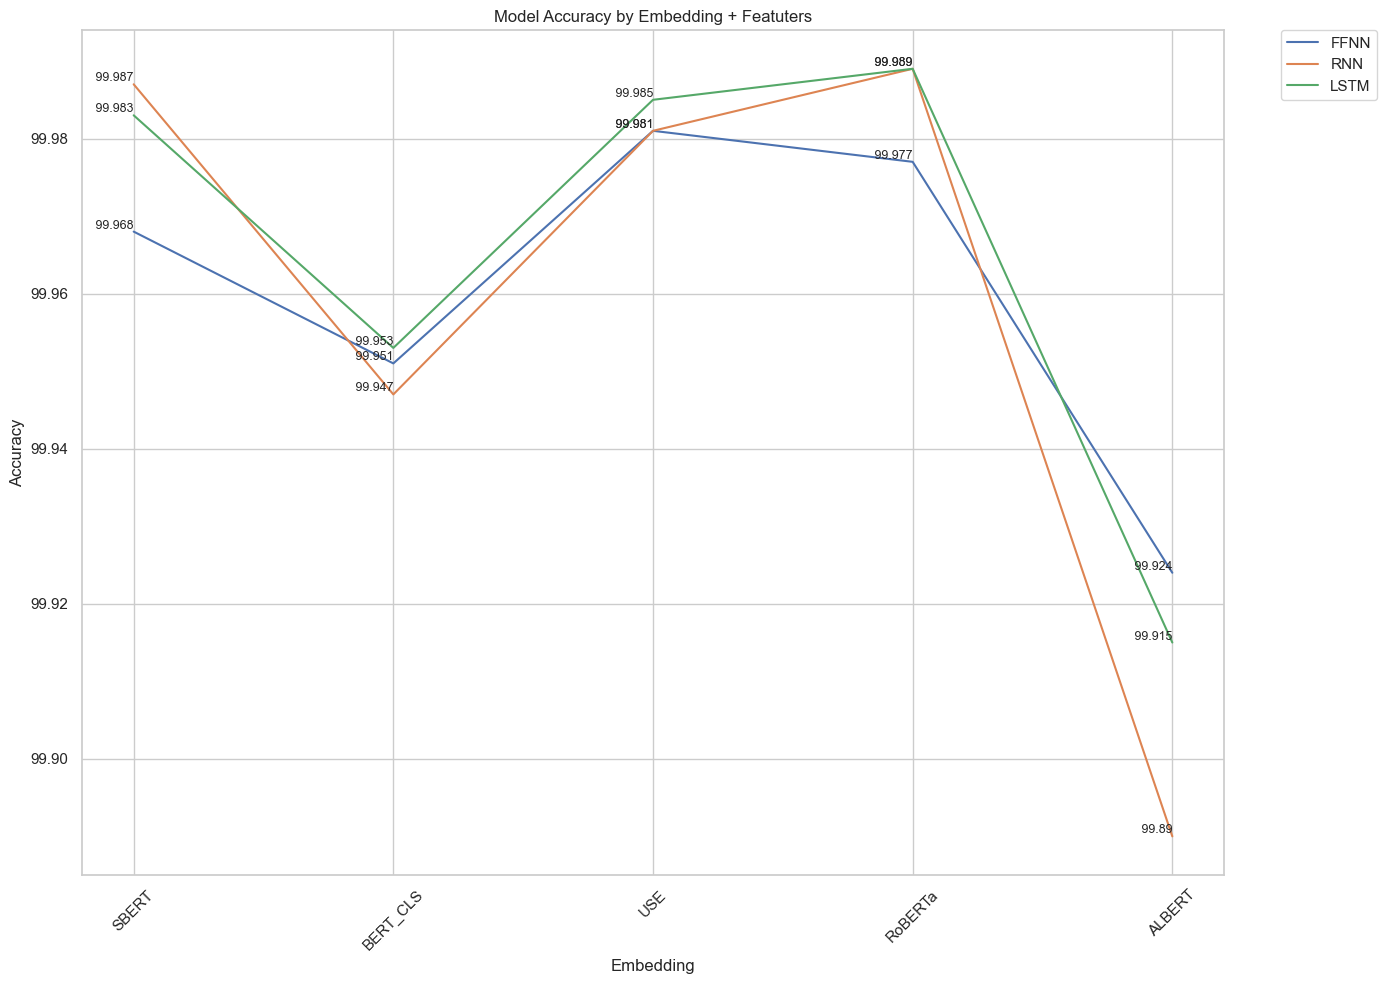

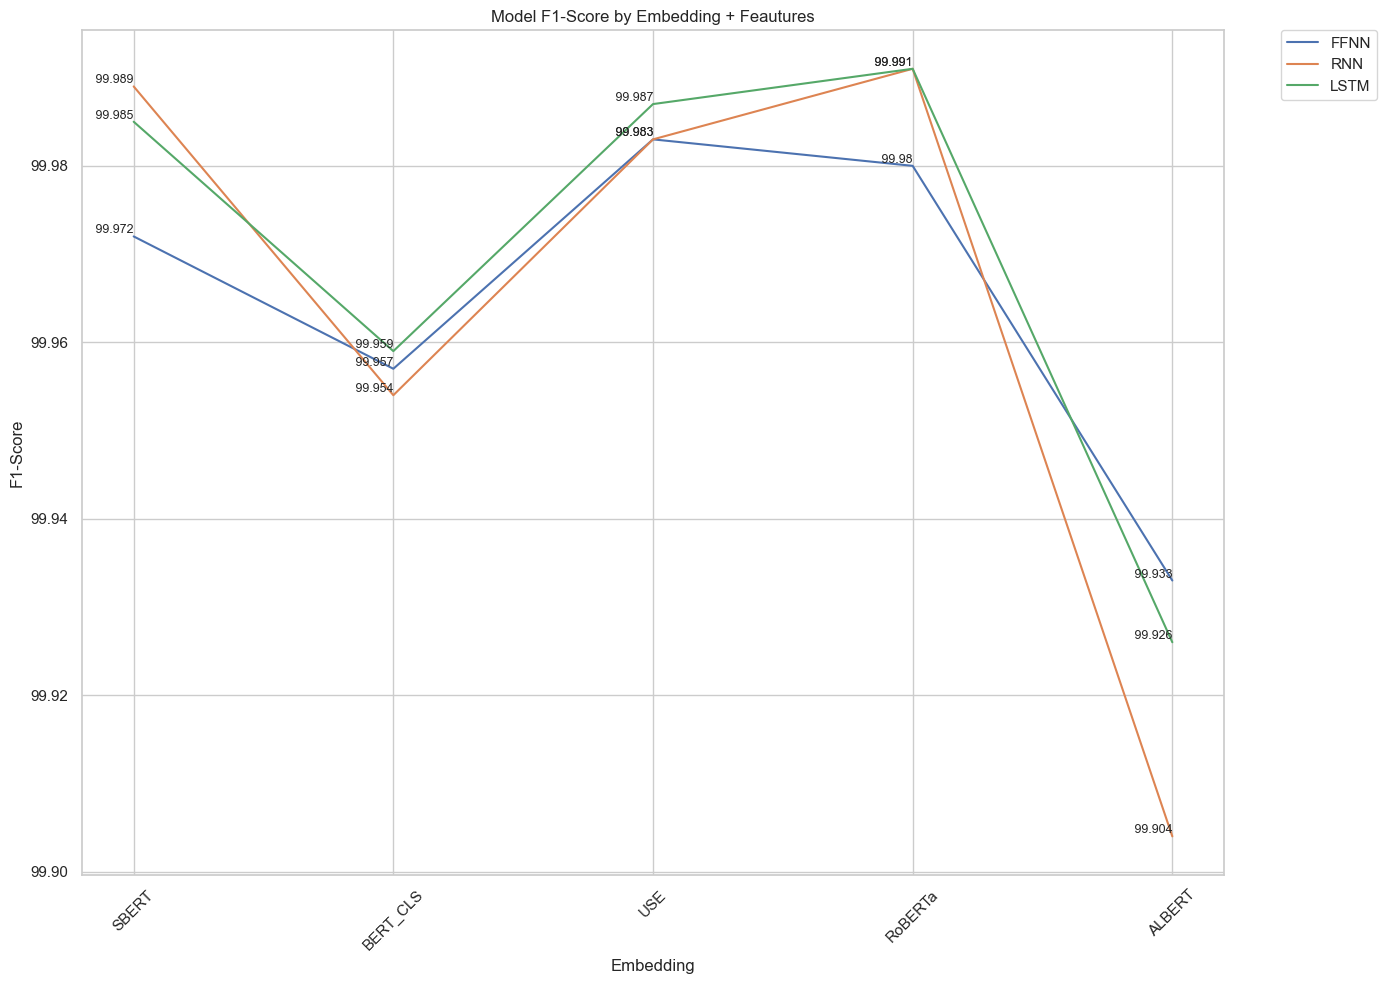

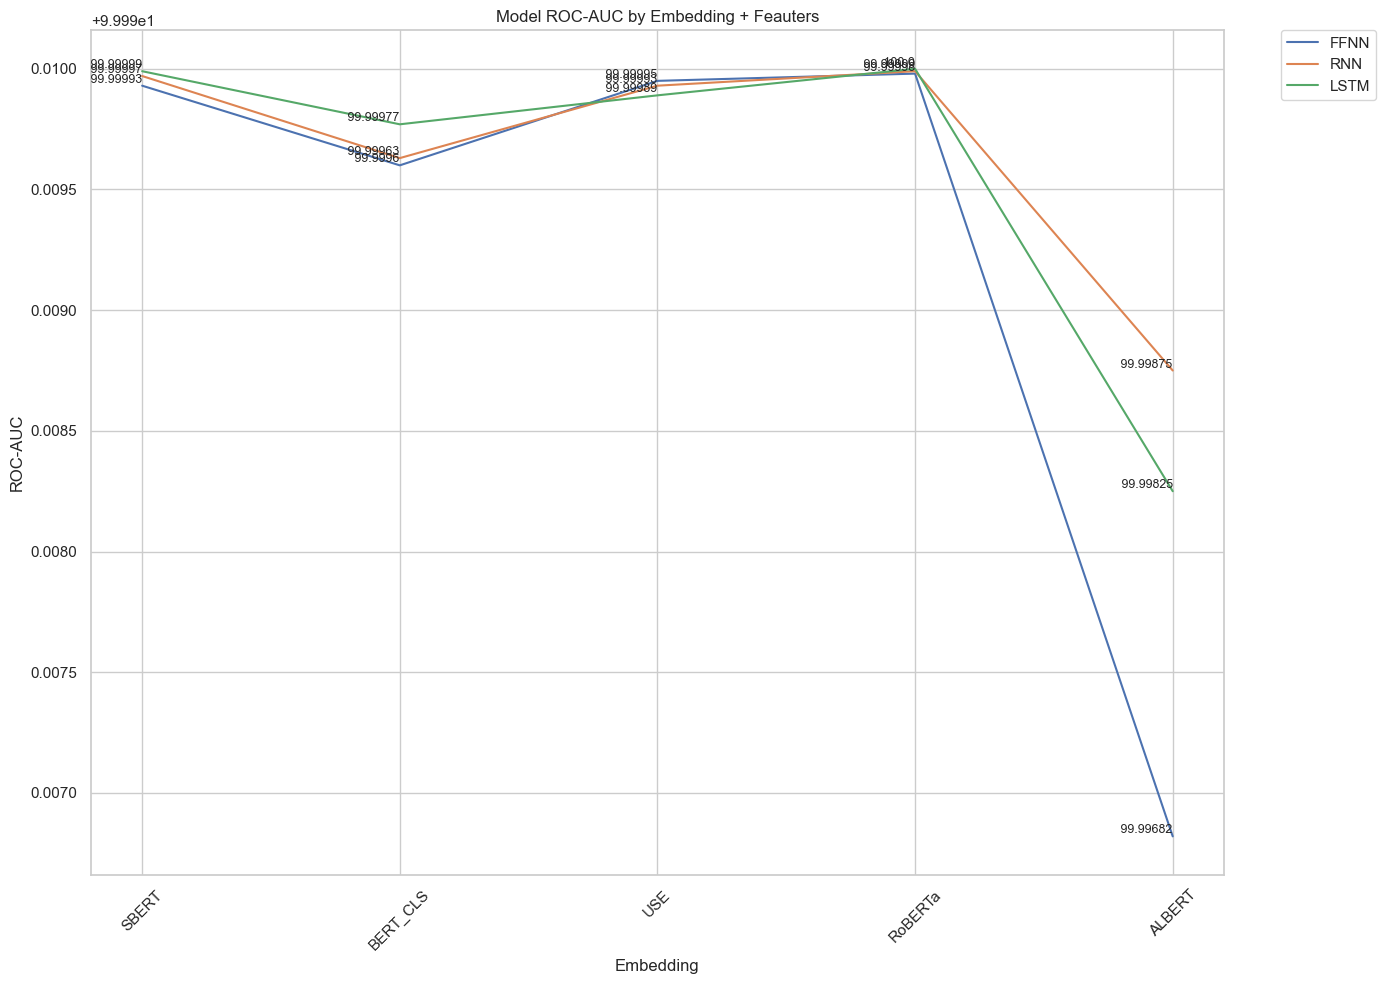

In [41]:
# Convert results to DataFrame
results_df = pd.DataFrame(results_new)

# Display the results
print(results_df)

# Save the results for future reference
results_df.to_csv('model_embedding_results.csv', index=False)

# Visualization (as defined earlier)
import matplotlib.pyplot as plt
import seaborn as sns
a,b=14,10
sns.set(style="whitegrid")
plt.figure(figsize=(a, b))
sns.lineplot(x='Embedding', y='Accuracy', hue='Model',markers='o', data=results_df)
for i in range(len(results_df)):
    plt.text(results_df['Embedding'][i], results_df['Accuracy'][i], f' {results_df["Accuracy"][i]}', 
             fontsize=9, verticalalignment='bottom', horizontalalignment='right')
plt.title('Model Accuracy by Embedding + Featuters')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()
# # Accuracy
# plt.figure(figsize=(14, 10))
# sns.barplot(x='Embedding', y='Accuracy', hue='Model', data=results_df)
# plt.title('Model Accuracy by Embedding')
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.tight_layout()
# plt.show()

# F1-Score
plt.figure(figsize=(14, 10))
sns.lineplot(x='Embedding', y='F1-Score', hue='Model', data=results_df)
for i in range(len(results_df)):
    plt.text(results_df['Embedding'][i], results_df['F1-Score'][i], f' {results_df["F1-Score"][i]}', 
             fontsize=9, verticalalignment='bottom', horizontalalignment='right')
plt.title('Model F1-Score by Embedding + Feautures')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

# ROC-AUC
plt.figure(figsize=(14, 10))
sns.lineplot(x='Embedding', y='ROC-AUC', hue='Model', data=results_df)
for i in range(len(results_df)):
    plt.text(results_df['Embedding'][i], results_df['ROC-AUC'][i], f' {results_df["ROC-AUC"][i]}',
             fontsize=9, verticalalignment='bottom', horizontalalignment='right')
plt.title('Model ROC-AUC by Embedding + Feauters')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()


In [ ]:
# Example: Accuracy Matrix
accuracy_matrix = results.pivot(index='Model', columns='Embedding', values='Accuracy')
print("Accuracy Matrix:")
print(accuracy_matrix)

# Similarly, you can create matrices for F1 Score, Precision, Recall
f1_matrix = results.pivot(index='Model', columns='Embedding', values='F1_Score')
precision_matrix = results.pivot(index='Model', columns='Embedding', values='Precision')
recall_matrix = results.pivot(index='Model', columns='Embedding', values='Recall')

# To save the results
results.to_csv('model_embedding_results.csv', index=False)